In [1]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import *
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

In [2]:
data = pd.read_csv('sample.txt')

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

# 1.do simple Transformation for dense features
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

# 2.set hashing space for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=1000, embedding_dim=4, use_hash=True, dtype='string')
                            # since the input is string
                            for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                            for feat in dense_features]

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns, )


In [3]:
# 3.generate input data for model

train, test = train_test_split(data, test_size=0.2, random_state=2020)

train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

In [6]:
# 4.Define Model,train,predict and evaluate
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",
                metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=30, verbose=2, validation_split=0.2, )

Epoch 1/30
1/1 - 4s - loss: 0.6540 - binary_crossentropy: 0.6540 - val_loss: 0.6337 - val_binary_crossentropy: 0.6337
Epoch 2/30
1/1 - 0s - loss: 0.6372 - binary_crossentropy: 0.6372 - val_loss: 0.6271 - val_binary_crossentropy: 0.6270
Epoch 3/30
1/1 - 0s - loss: 0.6228 - binary_crossentropy: 0.6228 - val_loss: 0.6206 - val_binary_crossentropy: 0.6206
Epoch 4/30
1/1 - 0s - loss: 0.6091 - binary_crossentropy: 0.6091 - val_loss: 0.6142 - val_binary_crossentropy: 0.6141
Epoch 5/30
1/1 - 0s - loss: 0.5957 - binary_crossentropy: 0.5957 - val_loss: 0.6076 - val_binary_crossentropy: 0.6076
Epoch 6/30
1/1 - 0s - loss: 0.5823 - binary_crossentropy: 0.5823 - val_loss: 0.6013 - val_binary_crossentropy: 0.6013
Epoch 7/30
1/1 - 0s - loss: 0.5687 - binary_crossentropy: 0.5687 - val_loss: 0.5951 - val_binary_crossentropy: 0.5951
Epoch 8/30
1/1 - 0s - loss: 0.5547 - binary_crossentropy: 0.5547 - val_loss: 0.5893 - val_binary_crossentropy: 0.5893
Epoch 9/30
1/1 - 0s - loss: 0.5404 - binary_crossentropy

c:\Users\OMEN\anaconda3\envs\deepctr\lib\site-packages\ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app
c:\Users\OMEN\anaconda3\envs\deepctr\lib\site-packages\ipykernel_launcher.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  app.launch_new_instance()


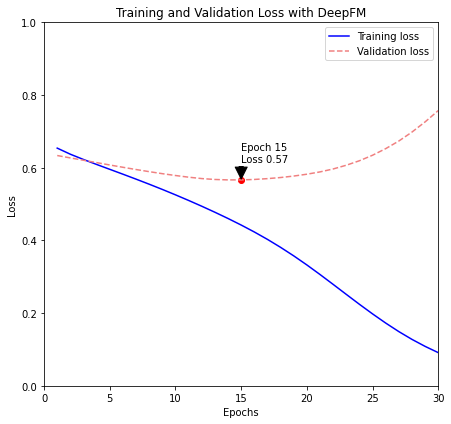

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_list = range(1, len(loss) + 1)

#getting lowest val_loss
min_loss_epoch = epochs_list[val_loss.index(min(val_loss))]
min_loss_value = min(val_loss)


# Plotting the Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, loss, 'b-', label='Training loss', color='blue')
plt.plot(epochs_list, val_loss, 'r--', label='Validation loss', color='lightcoral')
plt.scatter(min_loss_epoch, min_loss_value, color='red')  # Red dot at minimum validation loss
plt.annotate(f'Epoch {min_loss_epoch}\nLoss {min_loss_value:.2f}',
             xy=(min_loss_epoch, min_loss_value),
             xytext=(min_loss_epoch, min_loss_value + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Training and Validation Loss with DeepFM')
ax = plt.gca()
ax.set_xlim([0,30])
ax.set_ylim([0,1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.4365
test AUC 0.8781
